In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

In [3]:
df = pd.read_csv('output/engineered_sample_loan_data.csv')

In [4]:
df.shape

(178687, 42)

In [5]:
df.head()

,acc_now_delinq,annual_inc,individual_application,avg_cur_bal,bc_util,delinq_2yrs,dti,emp_length,inq_last_6mths,installment,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,fully_paid
0,0.0,60000.0,1,7483.0,54.7,0.0,8.32,6,0.0,160.03,...,False,False,False,False,True,False,False,False,False,1
1,0.0,67080.0,1,32793.0,48.9,0.0,10.54,10,1.0,153.30,...,False,False,False,False,False,False,False,True,False,1
2,0.0,44000.0,1,2856.0,42.5,0.0,27.13,0,1.0,306.10,...,False,False,False,False,False,False,False,False,False,0
3,0.0,235000.0,1,33219.0,46.6,0.0,9.87,8,0.0,511.71,...,False,False,False,False,False,False,False,False,False,1
4,0.0,20700.0,1,464.0,61.2,0.0,11.71,0,0.0,141.11,...,False,False,False,False,False,False,False,False,False,0


In [6]:
# List all non-numeric columns
non_numeric_columns = df.select_dtypes(include=['object']).columns
non_numeric_columns


Index(['issue_d'], dtype='object')

In [7]:
# Drop all non-numeric columns
df = df.drop(columns=non_numeric_columns)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178687 entries, 0 to 178686
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   acc_now_delinq              178687 non-null  float64
 1   annual_inc                  178687 non-null  float64
 2   individual_application      178687 non-null  int64  
 3   avg_cur_bal                 178687 non-null  float64
 4   bc_util                     178687 non-null  float64
 5   delinq_2yrs                 178687 non-null  float64
 6   dti                         178687 non-null  float64
 7   emp_length                  178687 non-null  int64  
 8   inq_last_6mths              178687 non-null  float64
 9   installment                 178687 non-null  float64
 10  int_rate                    178687 non-null  float64
 11  loan_amnt                   178687 non-null  float64
 12  pub_rec                     178687 non-null  float64
 13  pub_rec_bankru

### Train/Test Split


In [9]:
# Set the feature variables
X = df.drop(columns='fully_paid')

# Set the target variable
y = df['fully_paid']

In [10]:
# Split the data into 4/5 training and 1/5 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


### Models Setup

In [11]:
columns_to_scale = ['acc_now_delinq', 'annual_inc', 'avg_cur_bal', 'bc_util', 'delinq_2yrs', 'dti',
       'emp_length', 'sub_grade', 'inq_last_6mths', 'installment', 'int_rate', 'loan_amnt', 'pub_rec', 
       'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'term', 'verification_status', 'fico_avg']

preprocessor = make_column_transformer(
    (StandardScaler(), columns_to_scale),
    remainder="passthrough", 
    verbose_feature_names_out=False
)

#### Baseline Model

We will use a dummy classifier with the `most_frequent` strategy as the worst-case scenario given the significant class imbalance.


In [12]:
# Create a pipeline with a Logistic Regression model
pipe_dummy = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyClassifier(strategy="most_frequent", random_state=42))
])
pipe_dummy

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acc_now_delinq',
                                                   'annual_inc', 'avg_cur_bal',
                                                   'bc_util', 'delinq_2yrs',
                                                   'dti', 'emp_length',
                                                   'sub_grade',
                                                   'inq_last_6mths',
                                                   'installment', 'int_rate',
                                                   'loan_amnt', 'pub_rec',
                                                   'pub_rec_bankruptcies',
                                                   'revol_bal', 'revol_util',
                                                   'term',
                                                   'verification_status',
                                                   'fico_avg'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 DummyClassifier(random_state=42, strategy='most_frequent'))])

#### Logistic Regression Model

In [13]:
# Create a pipeline with a Logistic Regression model
pipe_logistic_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42, n_jobs=-1))
])
pipe_logistic_reg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['acc_now_delinq',
                                                   'annual_inc', 'avg_cur_bal',
                                                   'bc_util', 'delinq_2yrs',
                                                   'dti', 'emp_length',
                                                   'sub_grade',
                                                   'inq_last_6mths',
                                                   'installment', 'int_rate',
                                                   'loan_amnt', 'pub_rec',
                                                   'pub_rec_bankruptcies',
                                                   'revol_bal', 'revol_util',
                                                   'term',
                                                   'verification_status',
                                                   'fico_avg'])],
                                   verbose_feature_names_out=False)),
                ('model', LogisticRegression(n_jobs=-1, random_state=42))])

#### K-Nearest Neighbors

In [ ]:
# Create a pipeline with a KNN model
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

#### Decision Trees

In [14]:
# Create a pipeline with a Decision Tree model
pipe_dtree = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])


#### Support Vector Machines (SVM)

In [ ]:
# Create a pipeline with a Decision Tree model
pipe_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVC(probability=True, random_state=42))
])


### Model Comparisons


In [15]:
models = [
    'Baseline - DummyClassifer', 
    'Logistic Regression', 
#    'KNN', 
    'Decision Tree', 
#    'SVM'
]

pipe_dict = {
    'Baseline - DummyClassifer': pipe_dummy, 
    'Logistic Regression': pipe_logistic_reg, 
#    'KNN': pipe_knn, 
    'Decision Tree': pipe_dtree, 
#    'SVM': pipe_svm
}

train_times = {}
train_acc_dict = {}
test_acc_dict = {}
probabilities_dict = {}
roc_dict = {}
roc_auc_score_dict = {}

for model in models:
    print(model)
    start_time = dt.datetime.now()
    pipe_dict[model].fit(X_train, y_train)
    train_times[model] = dt.datetime.now() - start_time

    predictions = pipe_dict[model].predict(X_test)

    if model != 'Baseline - DummyClassifer':
        print(classification_report(y_test, predictions, zero_division=0))
    else:
        print(classification_report(y_test, predictions))

    train_acc_dict[model] = pipe_dict[model].score(X_train, y_train)
    test_acc_dict[model] = pipe_dict[model].score(X_test, y_test)

    probabilities_dict[model] = pipe_dict[model].predict_proba(X_test)[:, 1]
    roc_dict[model] = roc_curve(y_test, probabilities_dict[model])
    roc_auc_score_dict[model] = roc_auc_score(y_test, probabilities_dict[model])


Baseline - DummyClassifer
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7204
           1       0.80      1.00      0.89     28534

    accuracy                           0.80     35738
   macro avg       0.40      0.50      0.44     35738
weighted avg       0.64      0.80      0.71     35738



/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Logistic Regression
              precision    recall  f1-score   support

           0       0.53      0.08      0.14      7204
           1       0.81      0.98      0.89     28534

    accuracy                           0.80     35738
   macro avg       0.67      0.53      0.51     35738
weighted avg       0.75      0.80      0.74     35738

Decision Tree
              precision    recall  f1-score   support

           0       0.27      0.30      0.29      7204
           1       0.82      0.80      0.81     28534

    accuracy                           0.70     35738
   macro avg       0.55      0.55      0.55     35738
weighted avg       0.71      0.70      0.70     35738



In [16]:
summary_df = pd.DataFrame({
    'Model': models,
    'Train Time (Seconds)': np.array(train_times.values()),
    'Train Accuracy': list(train_acc_dict.values()),
    'Test Accuracy': list(test_acc_dict.values()),
    'ROC-AUC Score': list(roc_auc_score_dict.values())
})
summary_df

,Model,Train Time (Seconds),Train Accuracy,Test Accuracy,ROC-AUC Score
0,Baseline - DummyClassifer,0:00:00.108719,0.795717,0.798422,0.500000
1,Logistic Regression,0:00:00.920505,0.797033,0.800464,0.706320
2,Decision Tree,0:00:02.044501,1.000000,0.698388,0.550253


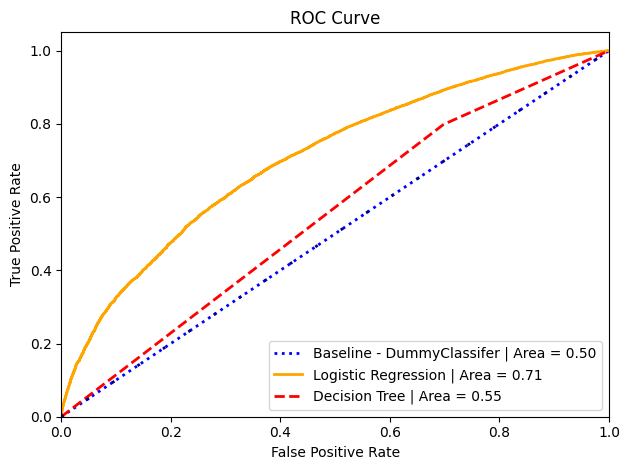

In [17]:
color_dict = {
    'Baseline - DummyClassifer': 'blue', 
    'Logistic Regression': 'orange', 
#    'KNN': 'green', 
    'Decision Tree': 'red', 
#    'SVM': 'purple'
}
linestyle_dict = {
    'Baseline - DummyClassifer': 'dotted',
    'Logistic Regression': 'solid', 
#    'KNN': 'dotted', 
    'Decision Tree': 'dashed', 
#    'SVM': 'dashdot'
}
# Plot curves
plt.figure()
for model in models:
    fpr, tpr, thresholds = roc_dict[model]
    roc_auc = roc_auc_score_dict[model]
    plt.plot(fpr, tpr, color=color_dict[model], linestyle = linestyle_dict[model], lw = 2, label=f'{model} | Area = {roc_auc:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=(0, (1, 10)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Model Tuning

We will use GridSearch to find optimal hyperparameters for our models.  Since we are dealing with an imbalance target class, accuracy is not the best metric to use for scoring.  Recall measures how well a model identifies all actual positives.  It is the proportion of true positives among all actual positives.  For a marketing campaign, a high recall means capturing as many interested customers as possible, even if it includes contacting some who are not interested.

In [18]:
tuned_train_acc_dict = {}
tuned_test_acc_dict = {}
tuned_probabilities_dict = {}
tuned_roc_dict = {}
tuned_roc_auc_score_dict = {}

#### Logistic Regression

From prior runs, our best parameters and score were as follows:

Best parameters: `{'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}`

Score for best Logistic Regression estimator:  0.80

In [19]:
# search over different penalty options
lr_params = {
    'model__C': [0.1, 1, 10, 100],  # smaller values specify stronger regularization
    'model__penalty': ['l1', 'l2'], # l1 is Lasso, l2 is Ridge
    'model__solver': ['liblinear']  # lbfgs supports only 'l2'
}

lr_search = GridSearchCV(pipe_logistic_reg, lr_params, scoring='recall', error_score='raise')

lr_search.fit(X_train, y_train)

/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/ven

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['acc_now_delinq',
                                                                          'annual_inc',
                                                                          'avg_cur_bal',
                                                                          'bc_util',
                                                                          'delinq_2yrs',
                                                                          'dti',
                                                                          'emp_length',
                                                                          'sub_grade',
                                                                          'inq_last_6mths',
                                                                          'installment',
                                                                          'int_rate',
                                                                          'loan_amnt',
                                                                          'pub_rec',
                                                                          'pub_rec_bankruptcies',
                                                                          'revol_bal',
                                                                          'revol_util',
                                                                          'term',
                                                                          'verification_status',
                                                                          'fico_avg'])],
                                                          verbose_feature_names_out=False)),
                                       ('model',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=42))]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear']},
             scoring='recall')

In [20]:
best_lr_model = lr_search.best_estimator_

lr_score = best_lr_model.score(X_test, y_test)

print(f'Best parameters: {lr_search.best_params_}')
print(f'Score for best Logistic Regression estimator: {lr_score: .2f}')

Best parameters: {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Score for best Logistic Regression estimator:  0.80


In [21]:
model = 'Logistic Regression'
print(classification_report(y_test, best_lr_model.predict(X_test)))

tuned_train_acc_dict[model] = best_lr_model.score(X_train, y_train)
tuned_test_acc_dict[model] = best_lr_model.score(X_test, y_test)

tuned_probabilities_dict[model] = best_lr_model.predict_proba(X_test)[:, 1]
tuned_roc_dict[model] = roc_curve(y_test, tuned_probabilities_dict[model])
tuned_roc_auc_score_dict[model] = roc_auc_score(y_test, tuned_probabilities_dict[model])

              precision    recall  f1-score   support

           0       0.54      0.08      0.14      7204
           1       0.81      0.98      0.89     28534

    accuracy                           0.80     35738
   macro avg       0.67      0.53      0.51     35738
weighted avg       0.75      0.80      0.74     35738



#### KNN

In [ ]:
knn_params = {
    'model__n_neighbors': range(1, 20, 2),
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_search = GridSearchCV(pipe_knn, knn_params, scoring='recall')
knn_search.fit(X_train, y_train)

In [ ]:
best_knn_model = knn_search.best_estimator_

knn_score = best_knn_model.score(X_test, y_test)

print(f'Best parameters: {knn_search.best_params_}')
print(f'Score for best KNN estimator: {knn_score: .2f}')

In [ ]:
model = 'KNN'
print(classification_report(y_test, best_knn_model.predict(X_test)))

tuned_train_acc_dict[model] = best_knn_model.score(X_train, y_train)
tuned_test_acc_dict[model] = best_knn_model.score(X_test, y_test)

tuned_probabilities_dict[model] = best_knn_model.predict_proba(X_test)[:, 1]
tuned_roc_dict[model] = roc_curve(y_test, tuned_probabilities_dict[model])
tuned_roc_auc_score_dict[model] = roc_auc_score(y_test, tuned_probabilities_dict[model])

In [ ]:
knn_cv_df = pd.DataFrame(knn_search.cv_results_['params'])
knn_cv_df['score'] = knn_search.cv_results_['mean_test_score']
knn_cv_df

In [ ]:
#plot knn scores
knn_cv_df = pd.DataFrame(knn_search.cv_results_['params'])
knn_cv_df['score'] = knn_search.cv_results_['mean_test_score']
sns.lineplot(data=knn_cv_df, x='model__n_neighbors', y='score', hue='model__weights', style='model__metric')
plt.show()

#### Decision Tree

In [22]:
dt_params = {
    'model__max_depth': range(1, 15),
    'model__criterion': ['gini', 'entropy'],
    'model__max_features': ['auto', 'sqrt', 'log2'], # 'log_loss' criterion supports only 'auto
    'model__min_samples_leaf': [1, 2, 4],
    'model__min_samples_split': [2, 5, 10]
}

dt_search = GridSearchCV(pipe_dtree, dt_params, scoring='recall')
dt_search.fit(X_train, y_train)

/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1260 fits failed out of a total of 3780.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1260 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dm

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['acc_now_delinq',
                                                                          'annual_inc',
                                                                          'avg_cur_bal',
                                                                          'bc_util',
                                                                          'delinq_2yrs',
                                                                          'dti',
                                                                          'emp_length',
                                                                          'sub_grade',
                                                                          'inq_last_6mths',
                                                                          'installment',
                                                                          'int_rate',
                                                                          'loan_amnt',
                                                                          'pub_rec',
                                                                          'pub_rec_bankruptcies',
                                                                          'revol_bal',
                                                                          'revol_util',
                                                                          'term',
                                                                          'verification_status',
                                                                          'fico_avg'])],
                                                          verbose_feature_names_out=False)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(1, 15),
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='recall')

In [23]:
best_dt_model = dt_search.best_estimator_

dt_score = best_dt_model.score(X_test, y_test)

print(f'Best parameters: {dt_search.best_params_}')
print(f'Score for best Decision Tree estimator: {dt_score: .2f}')

Best parameters: {'model__criterion': 'gini', 'model__max_depth': 1, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Score for best Decision Tree estimator:  0.80


In [24]:
model = 'Decision Tree'
print(classification_report(y_test, best_dt_model.predict(X_test)))

tuned_train_acc_dict[model] = best_dt_model.score(X_train, y_train)
tuned_test_acc_dict[model] = best_dt_model.score(X_test, y_test)

tuned_probabilities_dict[model] = best_dt_model.predict_proba(X_test)[:, 1]
tuned_roc_dict[model] = roc_curve(y_test, tuned_probabilities_dict[model])
tuned_roc_auc_score_dict[model] = roc_auc_score(y_test, tuned_probabilities_dict[model])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7204
           1       0.80      1.00      0.89     28534

    accuracy                           0.80     35738
   macro avg       0.40      0.50      0.44     35738
weighted avg       0.64      0.80      0.71     35738



/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dmtrinh/Desktop/Berkeley-PC-ML-AI/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

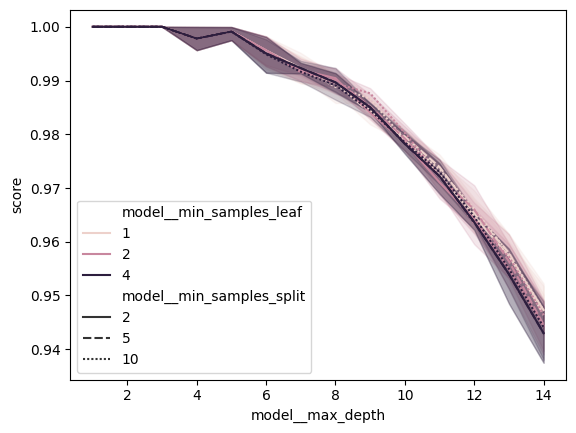

In [25]:
#plot decision tree scores
tree_cv_df = pd.DataFrame(dt_search.cv_results_['params'])
tree_cv_df['score'] = dt_search.cv_results_['mean_test_score']
sns.lineplot(data=tree_cv_df, x='model__max_depth', y='score', hue='model__min_samples_leaf', style='model__min_samples_split')
plt.show()

#### SVM

In [ ]:
svc_params = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__kernel': ['rbf'],
    'model__gamma': [1, 0.1, 0.01, 0.001],
}

svc_search = GridSearchCV(pipe_svm, svc_params, scoring='recall')
svc_search.fit(X_train, y_train)

In [ ]:
best_svc_model = svc_search.best_estimator_

svc_score = best_svc_model.score(X_test, y_test)

print(f'Best parameters: {svc_search.best_params_}')
print(f'Score for best Decision Tree estimator: {svc_score: .2f}')

In [ ]:
model = 'SVM'
print(classification_report(y_test, best_svc_model.predict(X_test)))

tuned_train_acc_dict[model] = best_svc_model.score(X_train, y_train)
tuned_test_acc_dict[model] = best_svc_model.score(X_test, y_test)

tuned_probabilities_dict[model] = best_svc_model.predict_proba(X_test)[:, 1]
tuned_roc_dict[model] = roc_curve(y_test, tuned_probabilities_dict[model])
tuned_roc_auc_score_dict[model] = roc_auc_score(y_test, tuned_probabilities_dict[model])

### Comparisons after hyperparameter tuning

In [26]:
#tuned_models = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM']
tuned_models = ['Logistic Regression', 'Decision Tree']

summary_df = pd.DataFrame({
    'Model': tuned_models,
    'Train Accuracy': list(tuned_train_acc_dict.values()),
    'Test Accuracy': list(tuned_test_acc_dict.values()),
    'ROC-AUC Score': list(tuned_roc_auc_score_dict.values())
})
summary_df

,Model,Train Accuracy,Test Accuracy,ROC-AUC Score
0,Logistic Regression,0.796935,0.800604,0.706298
1,Decision Tree,0.795717,0.798422,0.564265


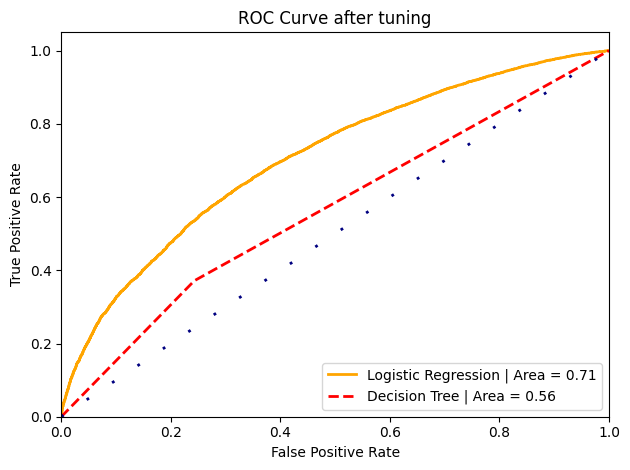

In [27]:
color_dict = {
    'Logistic Regression': 'orange', 
#    'KNN': 'green', 
    'Decision Tree': 'red', 
#    'SVM': 'purple'
}
linestyle_dict = {
    'Logistic Regression': 'solid', 
#    'KNN': 'dotted', 
    'Decision Tree': 'dashed', 
#    'SVM': 'dashdot'
}
# Plot curves
plt.figure()
for model in tuned_models:
    fpr, tpr, thresholds = tuned_roc_dict[model]
    roc_auc = tuned_roc_auc_score_dict[model]
    plt.plot(fpr, tpr, color=color_dict[model], linestyle = linestyle_dict[model], lw = 2, label=f'{model} | Area = {roc_auc:.2f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=(0, (1, 10)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve after tuning')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Feature importance

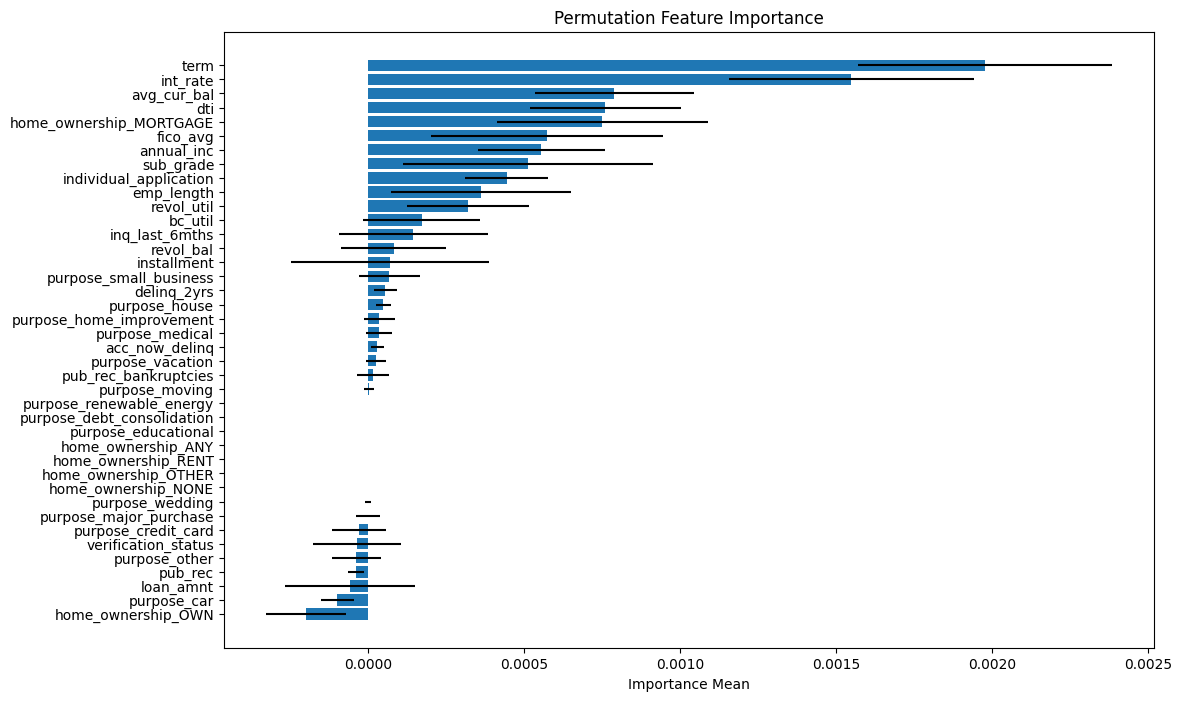

In [28]:
# Calculate permutation importance for Logistic Regression model
lr_perm_importance = permutation_importance(best_lr_model, X_test, y_test, n_repeats=30, random_state=42)

# Get the feature names
feature_names = X.columns

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': lr_perm_importance.importances_mean,
    'Importance Std': lr_perm_importance.importances_std
})

# Sort the DataFrame by importance mean
importances_df = importances_df.sort_values(by='Importance Mean', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'], importances_df['Importance Mean'], xerr=importances_df['Importance Std'])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.title('Permutation Feature Importance')
plt.xlabel('Importance Mean')
plt.show()

In [29]:
coefs = best_lr_model.named_steps.model.coef_
coefs[0]

array([ 0.00360329,  0.07225067,  0.11110472,  0.02365313, -0.00322046,
       -0.08006666,  0.08036422, -0.16894895, -0.05767546, -0.1016092 ,
       -0.25567387, -0.03197826, -0.00079148, -0.00298646,  0.04120441,
        0.03476055, -0.24275646, -0.02356615,  0.177248  ,  0.23673895,
        0.        ,  0.25378965,  0.        ,  0.        ,  0.06960156,
        0.        ,  0.11956844,  0.02371833,  0.        ,  0.        ,
       -0.027207  ,  0.05643286,  0.0291497 , -0.11917849, -0.0131832 ,
       -0.05283261,  0.        , -0.3737387 ,  0.04873309,  0.10857099])

In [30]:
# Create DataFrame with feature names and coefficients
coefs_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefs[0],
    'Abs_Coefs': np.abs(coefs[0])
})
coefs_df.sort_values(['Coefficient'], ascending = False).set_index('Feature')

,Coefficient,Abs_Coefs
Feature,,
home_ownership_MORTGAGE,0.253790,0.253790
fico_avg,0.236739,0.236739
verification_status,0.177248,0.177248
purpose_car,0.119568,0.119568
individual_application,0.111105,0.111105
purpose_wedding,0.108571,0.108571
dti,0.080364,0.080364
annual_inc,0.072251,0.072251
home_ownership_OWN,0.069602,0.069602
